---
# Create LGM initial conditions for CESM3-MOM6
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [xesmf](https://github.com/pangeo-data/xESMF)
- Other references
  - [Python scripts for the preindustrial ICs](https://github.com/NCAR/WOA_MOM6) by Gustavo Marques et al.
---

In [1]:
import subprocess
import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf

import warnings
warnings.filterwarnings('ignore')

---
## Examine the preindustrial initial condition for MOM6

depth range:    0.00, 5500.00
theta0 range:   -2.13,   32.52
s_an range:    3.75,   42.48


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, depth: 102)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    time     float32 ...
  * depth    (depth) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Data variables:
    s_an     (depth, lat, lon) float32 34.05 34.05 34.05 ... 34.92 34.92 34.92
    theta0   (depth, lat, lon) float32 -0.8227 -0.8227 -0.8227 ... -1.039 -1.039
Attributes:
    title:           T and S from WOA filled over continents
    WOA_resolution:  04, 01 (1 deg), 04 (0.25 deg)
    author:          Gustavo Marques (gmarques@ucar.edu)
    date:            2020-06-16T16:35:25.114337
    created_using:   create_filled_ic.py -path_out ./ -author Gustavo Marques...
    url:             create_filled_ic.py can be found at https://github.com/N...
    git_hash:        b'4b2f95e'

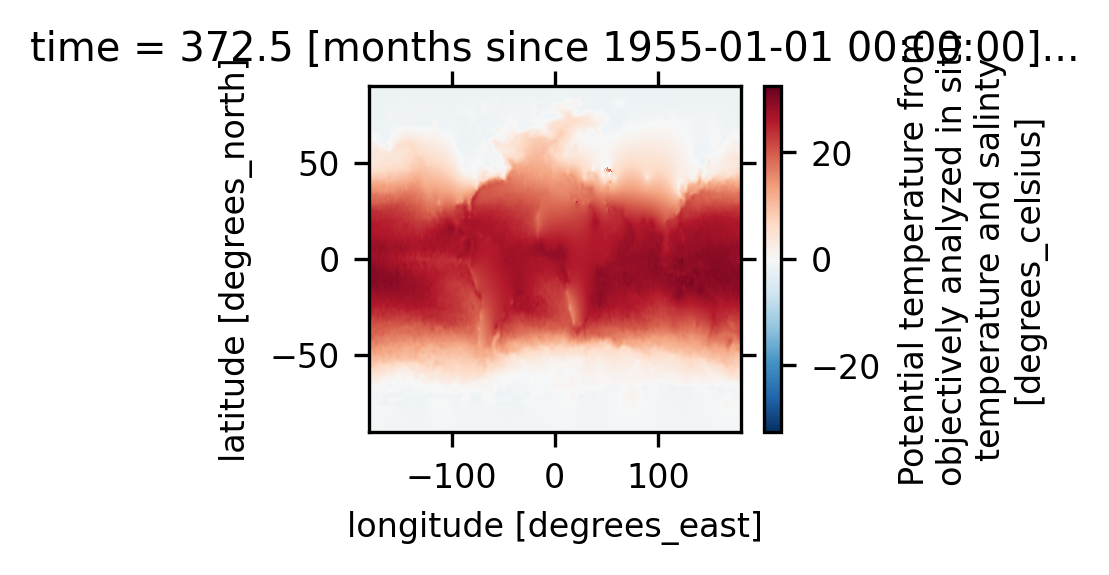

In [2]:
mom_pre = '/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/woa18_04_initial_conditions.nc'
ds_mom_pre = xr.open_dataset(mom_pre, decode_times=False)

print(f"depth range: {ds_mom_pre.depth.min().values:7.2f}, {ds_mom_pre.depth.max().values:7.2f}")
print(f"theta0 range: {ds_mom_pre.theta0.min().values:7.2f}, {ds_mom_pre.theta0.max().values:7.2f}")
print(f"s_an range: {ds_mom_pre.s_an.min().values:7.2f}, {ds_mom_pre.s_an.max().values:7.2f}")

ds_mom_pre.theta0.isel(depth=0).plot(size=1.5)
ds_mom_pre

---
## Create long-term means of LGM TEMP & SALT using CCSM4 with POP

In [3]:
%%time

pop_lgm_case = 'b40.lgm21ka.1deg.003'
pop_lgm_archive = '/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CCSM4/'

temp_file = f"{pop_lgm_archive}/{pop_lgm_case}/ocn/proc/tseries/month_1/{pop_lgm_case}.pop.h.TEMP.230101-240012.nc"
salt_file = f"{pop_lgm_archive}/{pop_lgm_case}/ocn/proc/tseries/month_1/{pop_lgm_case}.pop.h.SALT.230101-240012.nc"

ds_temp = xr.open_dataset(temp_file)['TEMP'].isel(time=slice(-600, None))
ds_salt = xr.open_dataset(salt_file)['SALT'].isel(time=slice(-600, None))
ds_pop_lgm = xr.Dataset({'TEMP': ds_temp, 'SALT': ds_salt}).mean('time')

ds_pop_lgm

CPU times: user 1min 52s, sys: 12.9 s, total: 2min 5s
Wall time: 2min 20s


<xarray.Dataset>
Dimensions:  (z_t: 60, nlat: 384, nlon: 320)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan

## Fill NaNs in the POP LGM fields
- We use the nearest neighbor to extrapolate, propogating values forward and backward (`xarray ffill & bfill`)

In [4]:
%%time

ds_pop_lgm_filled = ds_pop_lgm.copy(deep=True)

def fill_na(ds, n_points):
    for varname in ds.data_vars:
        while ds[varname].isnull().any():
            ds[varname] = ds[varname].ffill(dim='nlon', limit=n_points)
            ds[varname] = ds[varname].bfill(dim='nlon', limit=n_points)
            ds[varname] = ds[varname].ffill(dim='nlat', limit=n_points)
            ds[varname] = ds[varname].bfill(dim='nlat', limit=n_points)
    return ds

ds_pop_lgm_filled = fill_na(ds_pop_lgm_filled, n_points=1)
ds_pop_lgm_filled

CPU times: user 10.3 s, sys: 108 ms, total: 10.4 s
Wall time: 11.4 s


<xarray.Dataset>
Dimensions:  (z_t: 60, nlat: 384, nlon: 320)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float32 -1.804 -1.804 -1.804 ... -0.6943 -0.6943
    SALT     (z_t, nlat, nlon) float32 36.18 36.17 36.17 ... 36.09 36.09 36.09

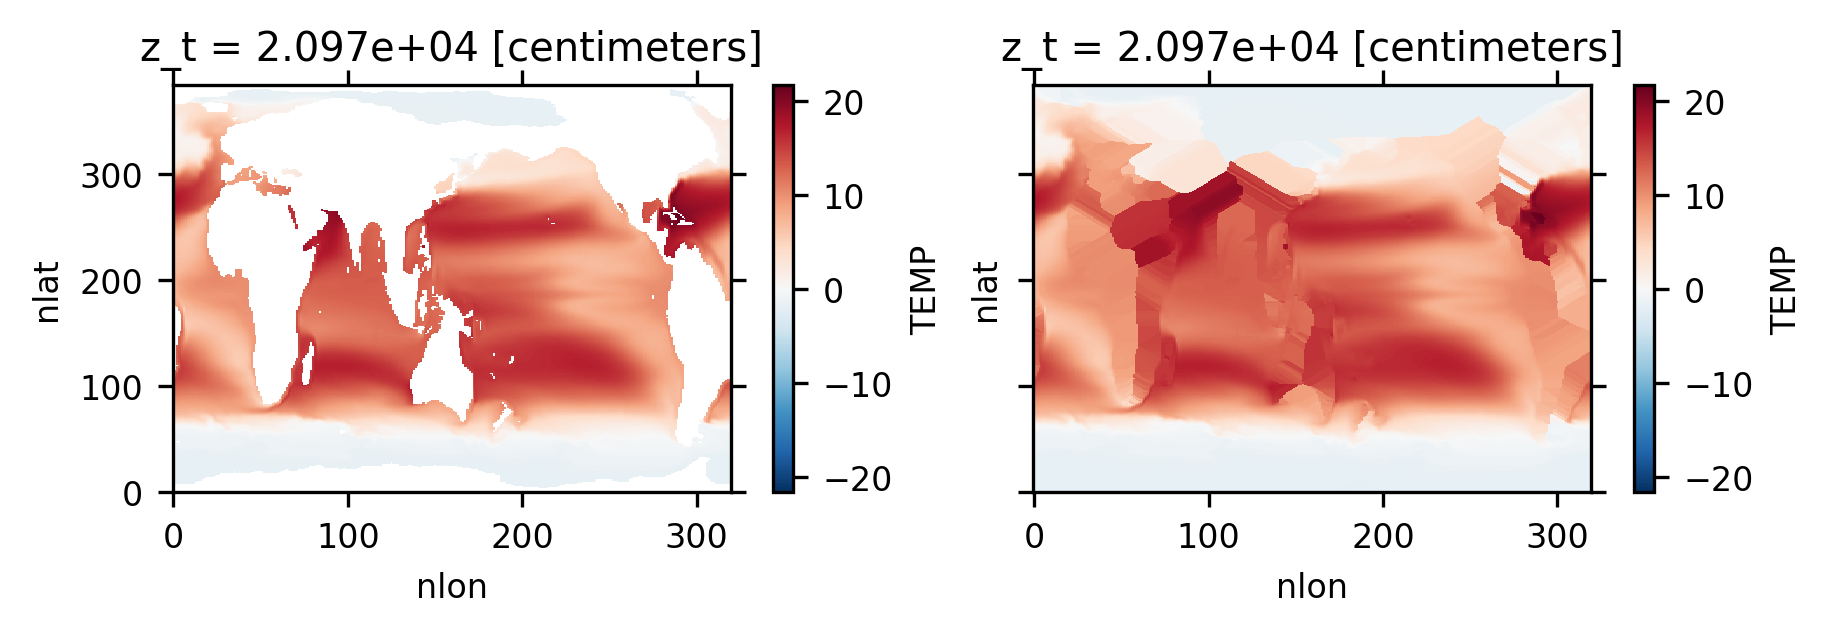

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, ds in zip(axes.ravel(), [ds_pop_lgm, ds_pop_lgm_filled]):
    ds.TEMP.isel(z_t=20).plot(ax=ax)

---
## Regrid to get the MOM LGM initial condition
- Remap in the horizontal direction first
- Interpolate in the vertical direction next

In [6]:
%%time

ds_pop_lgm_filled['lat'] = ds_pop_lgm_filled.TLAT
ds_pop_lgm_filled['lon'] = ds_pop_lgm_filled.TLONG

regridder = xesmf.Regridder(
    ds_pop_lgm_filled,
    ds_mom_pre,
    method='bilinear',
    extrap_method='nearest_s2d',
    periodic=True)

ds_pop_lgm_regrid = regridder(ds_pop_lgm_filled)
ds_pop_lgm_regrid

CPU times: user 1min 3s, sys: 3.75 s, total: 1min 7s
Wall time: 1min 20s


<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    time     float32 ...
Data variables:
    TEMP     (z_t, lat, lon) float32 -1.801 -1.801 -1.801 ... -1.531 -1.531
    SALT     (z_t, lat, lon) float32 36.04 36.04 36.04 ... 36.03 36.03 36.03
Attributes:
    regrid_method:  bilinear

In [7]:
ds_mom_lgm = ds_mom_pre.copy(deep=True)

ds_pop_lgm_regrid = ds_pop_lgm_regrid.rename(
    {'TEMP': 'theta0', 'SALT': 's_an', 'z_t': 'depth'})
ds_pop_lgm_regrid = ds_pop_lgm_regrid.assign_coords(
    depth=ds_pop_lgm_regrid.depth/100)

for v in ['theta0', 's_an']:
    ds_mom_lgm[v].data = ds_pop_lgm_regrid[v].interp(
        depth=ds_mom_pre.depth,
        method="linear",
        kwargs={"fill_value": "extrapolate"}
    )

print(f"depth range: {ds_mom_lgm.depth.min().values:7.2f}, {ds_mom_lgm.depth.max().values:7.2f}")
print(f"theta0 range: {ds_mom_lgm.theta0.min().values:7.2f}, {ds_mom_lgm.theta0.max().values:7.2f}")
print(f"s_an range: {ds_mom_lgm.s_an.min().values:7.2f}, {ds_mom_lgm.s_an.max().values:7.2f}")

depth range:    0.00, 5500.00
theta0 range:   -3.27,   27.22
s_an range:   21.26,   43.61


### Plot profiles for a sample point for validation

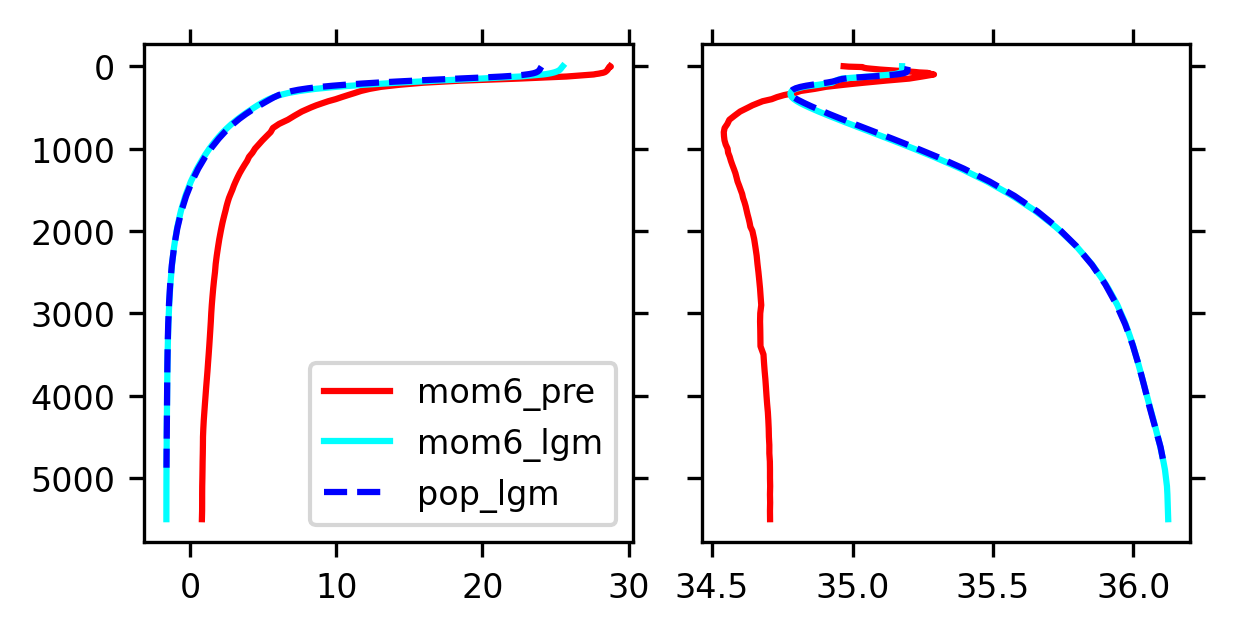

In [8]:
lat_pnt = 0
lon_pnt = 200
dxy = 0.5

fig, axes = plt.subplots(1, 2, figsize=(4, 2),
                         sharex=False, sharey=True,
                         constrained_layout=True)

for ax, vname in zip(axes, ['theta0', 's_an']):
    ax.plot(ds_mom_pre[vname].sel(lat=lat_pnt, lon=lon_pnt, method='nearest'),
            ds_mom_pre.depth, 'red', label='mom6_pre')
    ax.plot(ds_mom_lgm[vname].sel(lat=lat_pnt, lon=lon_pnt, method='nearest'),
            ds_mom_pre.depth, 'cyan', label='mom6_lgm')

for ax, vname in zip(axes, ['TEMP', 'SALT']):
    var_pop = ds_pop_lgm[vname].where(
        (lat_pnt-dxy < ds_pop_lgm.TLAT) & (ds_pop_lgm.TLAT < lat_pnt+dxy) &
        (lon_pnt-dxy < ds_pop_lgm.TLONG) & (ds_pop_lgm.TLONG < lon_pnt+dxy),
        drop=True).median(('nlat', 'nlon'))
    ax.plot(var_pop, var_pop.z_t/100, '--', color='blue', label='pop_lgm')

ax = axes[0]
hl, ll = ax.get_legend_handles_labels()
leg0 = ax.legend(hl, ll, loc='lower right')
ax.invert_yaxis()

---
## Save output

In [9]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2'

fname_mom_lgm = f"{pop_lgm_case}.TEMP_SALT.235101-240012.forMOM6_{today}.nc"
print(fname_mom_lgm)

ds_mom_lgm.attrs['Title']  = 'Initial condition file for MOM6 LGM'
ds_mom_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_mom_lgm.attrs['Source_file_1'] = temp_file
ds_mom_lgm.attrs['Source_file_2'] = salt_file
ds_mom_lgm.attrs['Script'] = 'create_mom6_initial_condition.fromCCSM4.ipynb'
ds_mom_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3_lgm'

ds_mom_lgm.to_netcdf(f'{work_dir}/{fname_mom_lgm}', format="NETCDF3_64BIT")

260119
b40.lgm21ka.1deg.003.TEMP_SALT.235101-240012.forMOM6_260119.nc
